# Terry Stop Legal Analysis and Prediction

## Project Overview

The goal of this project is to build a machine learning model that predicts whether an arrest was made following a Terry Stop. Using features such as the presence of weapons, the time of day, and other contextual factors recorded during the stop, the model classifies each case as either resulting in an arrest or not.
This is a binary classification problem.

## 1. Business Understanding

By analyzing this data, the project aims to:
- Understand whether gender, age, and reason for the stop influence the likelihood of an arrest.
- Develop a model that balances accuracy with justice.
- Explore patterns or potential biases in Terry Stops.
- Understand the bias in Arrests made. 


## 2. Data Understanding
Source of data : This data is from the Seattle Police Department. This data represents records of police reported stops under Terry v. Ohio, 392 U.S. 1 (1968). Each row represents a unique stop.

In [37]:
#Importing the needed Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt #For visualisations
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #First model
from sklearn.tree import DecisionTreeClassifier #Second model

In [38]:
#Load the data
df = pd.read_csv("Terry_Stops_20250507.csv")

In [39]:
#Look at the dataset
df.head(5)

Subject Age Group  Subject ID     GO / SC Num  Terry Stop ID  \
0           26 - 35  9770358745  20190000313099     9770376049   
1           26 - 35          -1  20160000282794         180985   
2           26 - 35          -1  20180000002480         438562   
3           36 - 45          -1  20180000065356         392012   
4      56 and Above          -1  20170000004325         309626   

  Stop Resolution Weapon Type Officer ID  Officer YOB Officer Gender  \
0   Field Contact           -       5653         1967              M   
1          Arrest     Handgun       6355         1970              F   
2   Field Contact         NaN       7564         1979              M   
3  Offense Report         NaN       7514         1987              M   
4   Field Contact         NaN       6783         1976              M   

                Officer Race  ...     Reported Time  \
0  Black or African American  ...  00:25:27.0000000   
1                      White  ...  07:09:00.0000000   
2         Declined to Answer  ...  13:50:00.0000000   
3                      White  ...  02:09:00.0000000   
4                      White  ...  15:00:00.0000000   

                          Initial Call Type  \
0                          SHOPLIFT - THEFT   
1                               DISTURBANCE   
2                                         -   
3  ROBBERY - CRITICAL (INCLUDES STRONG ARM)   
4                                         -   

                          Final Call Type Call Type  \
0  SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON    ONVIEW   
1                       NARCOTICS - OTHER       911   
2                                       -         -   
3                         ROBBERY - ARMED       911   
4                                       -         -   

                              Officer Squad Arrest Flag Frisk Flag Precinct  \
0      SOUTH PCT 2ND W - ROBERT - PLATOON 2           N          N        -   
1     EAST PCT 1ST W - E/G RELIEF (CHARLIE)           N          N     East   
2              WEST PCT 2ND W - DAVID BEATS           N          N        -   
3  NORTH PCT 3RD W - BOY (JOHN) - PLATOON 1           N          N    North   
4       EAST PCT 2ND W - GEORGE - PLATOON 2           N          N        -   

  Sector Beat  
0      -    -  
1      C   C3  
2      -    -  
3      L   L2  
4      -    -  

[5 rows x 23 columns]

In [40]:
#Number of rows and columns
df.shape

(63462, 23)

In [41]:
#Overview of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63462 entries, 0 to 63461
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject Age Group         63462 non-null  object
 1   Subject ID                63462 non-null  int64 
 2   GO / SC Num               63462 non-null  int64 
 3   Terry Stop ID             63462 non-null  int64 
 4   Stop Resolution           63462 non-null  object
 5   Weapon Type               30897 non-null  object
 6   Officer ID                63462 non-null  object
 7   Officer YOB               63462 non-null  int64 
 8   Officer Gender            63462 non-null  object
 9   Officer Race              63462 non-null  object
 10  Subject Perceived Race    63462 non-null  object
 11  Subject Perceived Gender  63462 non-null  object
 12  Reported Date             63462 non-null  object
 13  Reported Time             63462 non-null  object
 14  Initial Call Type     

Description and Size of data: The dataset contains 5,000 records with 8 categorical features, such as 'Arrest Made' (Yes/No). Most data types are objects, with only one date at  Officer YOB and three other IDs.

## 3. Data Preparation
The data preparation has 2 parts cleaning and preprocessing for modeling.

### Data cleaning
First, I will check for Nulls, duplicate rows and change the Officer YOB type in
to a date and the ID columns into strings to help with filtering and parsing.

In [42]:
#Finding Nulls
df.isna().sum()

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 561
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

In [43]:
#Fill in the nulls with N/A
df['Weapon Type'].fillna('NaN', inplace=True)
df['Officer Squad'].fillna('NaN', inplace=True)

In [44]:
#Looking for duplicate rows
df.duplicated().value_counts()

False    63462
Name: count, dtype: int64

There are no duplicate rows

In [45]:
#Convert data types for easy analysis
df['Officer YOB'] = pd.to_datetime(df['Officer YOB'], format='%Y')
df['Reported Date'] = pd.to_datetime(df['Reported Date'])
df[['Subject ID', 'GO / SC Num' ,'Terry Stop ID']] = df[['Subject ID', 'GO / SC Num' ,'Terry Stop ID']].astype(str)

In [46]:
#Overview of updated columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63462 entries, 0 to 63461
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   Subject Age Group         63462 non-null  object             
 1   Subject ID                63462 non-null  object             
 2   GO / SC Num               63462 non-null  object             
 3   Terry Stop ID             63462 non-null  object             
 4   Stop Resolution           63462 non-null  object             
 5   Weapon Type               63462 non-null  object             
 6   Officer ID                63462 non-null  object             
 7   Officer YOB               63462 non-null  datetime64[ns]     
 8   Officer Gender            63462 non-null  object             
 9   Officer Race              63462 non-null  object             
 10  Subject Perceived Race    63462 non-null  object             
 11  Subject Perceiv

In [47]:
#Clean the categories eg remove spaces and standardize 
df['Subject Age Group'] = df['Subject Age Group'].str.strip()
df['Subject Age Group'] = df['Subject Age Group'].str.replace(' - ', '-', regex=False)

In [48]:
#Clean the classification columns in Frisk Flag
'''
The frisk column will be a classification column and needs to be cleaned to only have Yes and No classifications which are two.
'''
df = df[df['Frisk Flag'] != '-']

### Detailed Overview of the data

I will have a further analysis of specific columns those that will later on be used as selected features, including the age group, and then a look at the trend of reports over time.

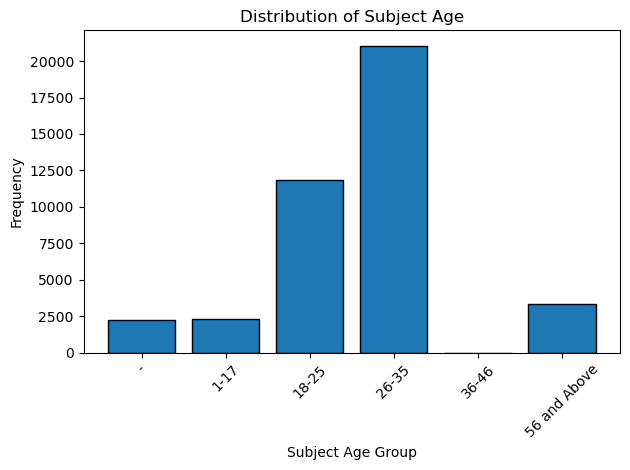

In [49]:
# Distribution of Subject Age (using bar instead, because I want to order the columns)
order = ['-', '1-17', '18-25', '26-35', '36-46', '56 and Above']

# Count the frequencies in your DataFrame
age_counts = df['Subject Age Group'].value_counts().reindex(order, fill_value=0)

plt.bar(age_counts.index, age_counts.values, edgecolor='black')
plt.title('Distribution of Subject Age')
plt.xlabel('Subject Age Group')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [50]:
#Overview of the Gender column values
gender_counts = df['Subject Perceived Gender'].value_counts()
gender_counts

Subject Perceived Gender
Male                                                         49777
Female                                                       12514
Unable to Determine                                            317
-                                                              199
Unknown                                                        113
Gender Diverse (gender non-conforming and/or transgender)       63
MULTIPLE SUBJECTS                                                1
Name: count, dtype: int64

In [51]:
#Simplifying and cleaning the gender column
df['Subject Perceived Gender'] = df['Subject Perceived Gender'].replace({'Gender Diverse (gender non-conforming and/or transgender)': 'Gender Diverse','-': 'Unknown','Unable to Determine': 'Unknown','MULTIPLE SUBJECTS': 'Unknown',
})

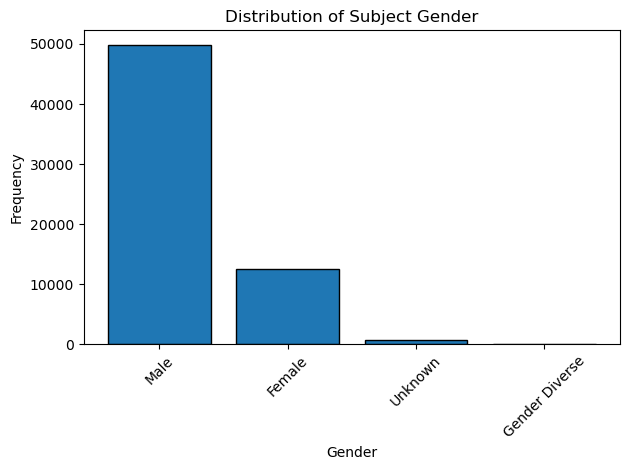

In [52]:
#Gender Distribution
gender_counts = df['Subject Perceived Gender'].value_counts()

plt.bar(gender_counts.index, gender_counts.values, edgecolor='black')
plt.title('Distribution of Subject Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

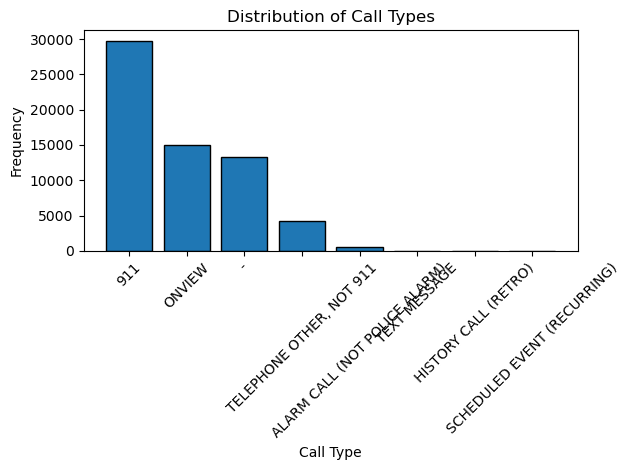

In [54]:
#Call Stops Distribution
call_counts = df['Call Type'].value_counts()

plt.bar(call_counts.index, call_counts.values, edgecolor='black')
plt.title('Distribution of Call Types')
plt.xlabel('Call Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

C:\Users\MichelleChekwooti\AppData\Local\Temp\ipykernel_17656\2507407185.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_trend = df['Reported Date'].dt.to_period('M').value_counts().sort_index()


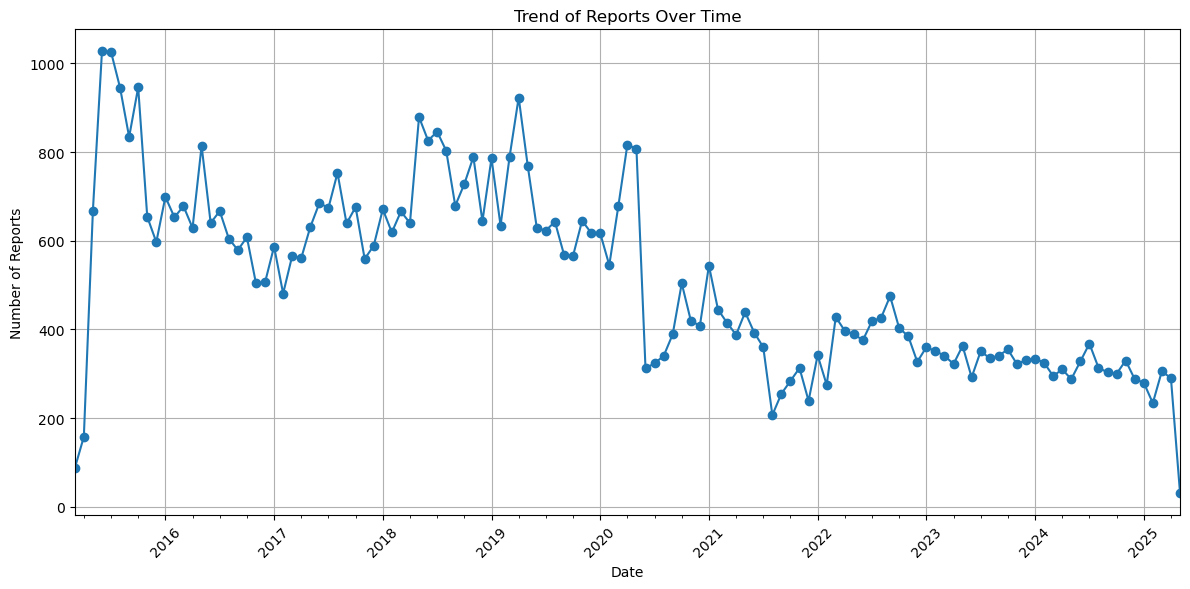

In [55]:
# trend of reports over time
df_trend = df['Reported Date'].dt.to_period('M').value_counts().sort_index()

df_trend.plot(kind='line', marker='o', figsize=(12, 6))
plt.title('Trend of Reports Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reports')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Preprocessing
I will now choose the X and Y and prepare them , this also includes looking for issues,one hot encoding and imbalance in the dataset.

In [56]:
#Convert the string values in the Y also.
df['Arrest Flag'] = df['Arrest Flag'].map({'N': 0, 'Y': 1})

In [57]:
# Define X and y
X = df[['Subject Age Group', 'Call Type', 'Subject Perceived Gender']]
y = df['Arrest Flag']

In [58]:
# One hot encoding to convert the categories
ohe = OneHotEncoder(sparse=False)
data_coded = X.copy()
data_coded

Subject Age Group                 Call Type Subject Perceived Gender
0                 26-35                    ONVIEW                     Male
1                 26-35                       911                     Male
2                 26-35                         -                     Male
3                 36-45                       911                   Female
4          56 and Above                         -                     Male
...                 ...                       ...                      ...
63457             36-45                    ONVIEW                   Female
63458              1-17                    ONVIEW                   Female
63459             26-35  TELEPHONE OTHER, NOT 911                     Male
63460                 -                    ONVIEW                   Female
63461             26-35                       911                     Male

[62984 rows x 3 columns]

In [59]:
#Fit the encoded data
X_encoded = ohe.fit_transform(data_coded)

C:\Users\MichelleChekwooti\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
#Find the column names and create a dataframe for the encoded figures
column_names = ohe.get_feature_names_out(data_coded.columns)

X_data = pd.DataFrame(X_encoded, columns=column_names)
X_data

Subject Age Group_-  Subject Age Group_1-17  Subject Age Group_18-25  \
0                      0.0                     0.0                      0.0   
1                      0.0                     0.0                      0.0   
2                      0.0                     0.0                      0.0   
3                      0.0                     0.0                      0.0   
4                      0.0                     0.0                      0.0   
...                    ...                     ...                      ...   
62979                  0.0                     0.0                      0.0   
62980                  0.0                     1.0                      0.0   
62981                  0.0                     0.0                      0.0   
62982                  1.0                     0.0                      0.0   
62983                  0.0                     0.0                      0.0   

       Subject Age Group_26-35  Subject Age Group_36-45  \
0                          1.0                      0.0   
1                          1.0                      0.0   
2                          1.0                      0.0   
3                          0.0                      1.0   
4                          0.0                      0.0   
...                        ...                      ...   
62979                      0.0                      1.0   
62980                      0.0                      0.0   
62981                      1.0                      0.0   
62982                      0.0                      0.0   
62983                      1.0                      0.0   

       Subject Age Group_46-55  Subject Age Group_56 and Above  Call Type_-  \
0                          0.0                             0.0          0.0   
1                          0.0                             0.0          0.0   
2                          0.0                             0.0          1.0   
3                          0.0                             0.0          0.0   
4                          0.0                             1.0          1.0   
...                        ...                             ...          ...   
62979                      0.0                             0.0          0.0   
62980                      0.0                             0.0          0.0   
62981                      0.0                             0.0          0.0   
62982                      0.0                             0.0          0.0   
62983                      0.0                             0.0          0.0   

       Call Type_911  Call Type_ALARM CALL (NOT POLICE ALARM)  \
0                0.0                                      0.0   
1                1.0                                      0.0   
2                0.0                                      0.0   
3                1.0                                      0.0   
4                0.0                                      0.0   
...              ...                                      ...   
62979            0.0                                      0.0   
62980            0.0                                      0.0   
62981            0.0                                      0.0   
62982            0.0                                      0.0   
62983            1.0                                      0.0   

       Call Type_HISTORY CALL (RETRO)  Call Type_ONVIEW  \
0                                 0.0               1.0   
1                                 0.0               0.0   
2                                 0.0               0.0   
3                                 0.0               0.0   
4                                 0.0               0.0   
...                               ...               ...   
62979                             0.0               1.0   
62980                             0.0               1.0   
62981                             0.0               0.0   
62982                        

## 4. Modeling

I will be using Logistic Regresstion and Decision tress.

Logistic Regresstion

I used this model because it is used for binary classification problems, where the outcome has only two possible values such as whether an arrest was made 1 or not 0. The model takes features and estimates the probability of an arrest occurring. Based on this probability, it predicts the outcome as either 0 or 1 which will help understanding patterns in the Terry Stop data.

In [61]:
#Split the data into Train and Test
'''
I chose a test size of 80% for training and a random state of 42.
'''
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.2, random_state=42)

In [62]:
#Look for class imbalance in the target variable
print("Class distribution ")
print(y_train.value_counts(normalize=True))
print("Class distribution")
print(y_test.value_counts(normalize=True))

Class distribution 
Arrest Flag
0    0.887987
1    0.112013
Name: proportion, dtype: float64
Class distribution
Arrest Flag
0    0.886084
1    0.113916
Name: proportion, dtype: float64


There is a large imbalance in the dataset with the majority being Not Arrested , 0 and the model will have trouble predicting when they are arrested. I have to reduce this imbalance by adjusting the class weights and using SMOTE to improve performance.

In [63]:
from imblearn.over_sampling import SMOTE

print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

Arrest Flag
0    55905
1     7079
Name: count, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

Arrest Flag
0    44743
1    44743
Name: count, dtype: int64


In [64]:
#Fitting the model
logreg = LogisticRegression(class_weight='balanced', fit_intercept=True, C=1e12, solver='liblinear')
baseline_model = logreg.fit(X_train_resampled, y_train_resampled)
baseline_model

LogisticRegression(C=1000000000000.0, class_weight='balanced',
                   solver='liblinear')

In [65]:
#Predict
y_pred_test = logreg.predict(X_test)

In [66]:
#Overview of the performance of the model
from sklearn.metrics import classification_report


report = classification_report(y_test, y_pred_test, target_names=['Not Arrested', 'Arrested'])
print(report)

              precision    recall  f1-score   support

Not Arrested       0.95      0.42      0.59     11162
    Arrested       0.16      0.83      0.26      1435

    accuracy                           0.47     12597
   macro avg       0.55      0.63      0.43     12597
weighted avg       0.86      0.47      0.55     12597



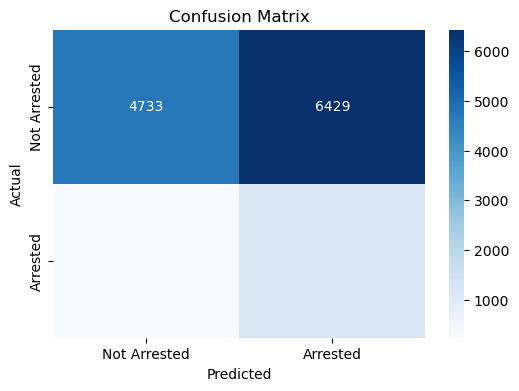

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# created a confusion matrix to overview the results
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Arrested', 'Arrested'], yticklabels=['Not Arrested', 'Arrested'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [32]:
'''
The performance metrics are quite low even after fixing imbalance,
The precision for Not arrested is 0.95, which shows it is very good at identifying
Not Arrested cases but has issue swith Arrested.
The recall for arrested is high at 0.83 so it gets the arrested cases well.
However the overall Accuracy is low at 0.47, meaning only a few predictions actually match
the actual outcomes. This is likely do to overfitting of the majority class,
Not Arrested.
'''

'\nThe performance metrics are quite low even after fixing imbalance,\nThe precision for Not arrested is 0.95, which shows it is very good at identifying\nNot Arrested cases but has issue swith Arrested.\nThe recall for arrested is high at 0.83 so it gets the arrested cases well.\nHowever the overall Accuracy is low at 0.47, meaning only a few predictions actually match\nthe actual outcomes. This is likely do to overfitting of the majority class,\nNot Arrested.\n'

Decition Tree

I am using a decition tree for my second model this is because it does not assume
a linear relationship and can handle complex pattens. It is also a classification model,
and will help evaluate the performace of the baseline model. I can evaluate whether a more flexible,
non-linear model improves prediction accuracy 

In [33]:
#Decision Tree classifier
clf = DecisionTreeClassifier(criterion='entropy',class_weight='balanced')
#Fit the model
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy')

In [34]:
y_preds_test2 = clf.predict(X_test)


In [35]:
#Overview of the performance of the model
report = classification_report(y_test, y_preds_test2, target_names=['Not Arrested', 'Arrested'])
print(report)

              precision    recall  f1-score   support

Not Arrested       0.95      0.42      0.59     11162
    Arrested       0.16      0.83      0.26      1435

    accuracy                           0.47     12597
   macro avg       0.55      0.63      0.42     12597
weighted avg       0.86      0.47      0.55     12597



In [68]:
'''
The precision for Not arrested is 0.95, which shows it is also very good at identifying Not Arrested cases but has issue swith Arrested.
The recall for arrested is high at 0.83 so it gets the arrested cases well also.
However the overall Accuracy is also low at 0.47, meaning only a few predictions actually match the actual outcomes.
'''

'\nThe precision for Not arrested is 0.95, which shows it is also very good at identifying Not Arrested cases but has issue swith Arrested.\nThe recall for arrested is high at 0.83 so it gets the arrested cases well also.\nHowever the overall Accuracy is also low at 0.47, meaning only a few predictions actually match the actual outcomes.\n'

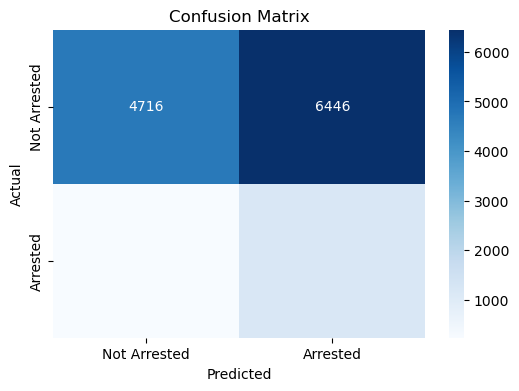

In [36]:
# Created a confusion matrix to look at the results
cm = confusion_matrix(y_test, y_preds_test2)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Arrested', 'Arrested'], yticklabels=['Not Arrested', 'Arrested'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## 5. Evaluation


Overview of take aways and conclusions 

- The data was highly imbalanced but considering how this is based, on arrests in the Chicago area and the nature of police work it is not considered abnormal to have a large number of Not Arrested in favour of Arrested.

- The aim was to be able to accurately predict an arrest when faced with a terry stop and the model that did this is the Logistic Regresstion once the imbalance was addressed.

- Both matrix show simiar results with no False negatives and True Positives. This means all people that were actually not arrested were predicted well, but the number of people that were actually not arrested when infact they were was also high. Very little true arrests were predicted. This means that both Type 1 and type 11 errors were found.